# A Two Parameter Plot of $k_{obs}$ vs. $\%H_2SO_4$ or $H_0$

This code explores the idea of interpreting the rate vs $a_{h_2O}$ taking into account more modern information about the pKa values and estimate of the $H_0$ value.

We will use data that states that the pKa of the ster carbonyl and oxygen group are different. On pKa value cannot be used accross the entire plot. As the plot is constructed, the two rate contributions due to carbonyl protonation and the ether oxygen protonation are additive. So the curve fit should be the addition of two linear regimes (I hope).


XXXin the discussion that plots $k_{obs}$ vs. $\% H_2SO_4$ and $\log{k_{obs}}$ vs $0.62H_0$ 

In [1]:
##############################################################
### Set up libraries and global variables
##############################################################
 
import interpolators   ### import the following functions from local library
# interpolators.MakeInterpolationFunctionForH0inH2SO4byPercentWt()
# interpolators.MakeInterpolationFunctionForH2OActivityinH2SO4byMoleFraction()
# interpolators.MakeInterpolationFunctionForH2OActivityinH2SO4byPercentWt()
# interpolators.MakeInterpolationFunctionForDensityofH2SO4byPercentWt()

import pandas as pd
pd.options.mode.chained_assignment = None    # no warning message and no exception is raised

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.optimize import curve_fit
from scipy.stats import linregress
from scipy.optimize import minimize
from scipy.optimize import minimize_scalar


from statsmodels.nonparametric.smoothers_lowess import lowess     # A function for interpolating a plot using the locally weighed scatterplot smoothing method. Returns smoothed x,y points
from scipy.interpolate import CubicSpline                         # A function for interpolating a plot using the cubic spline method. Returns an interpolation function.
from scipy.interpolate import interp1d                            # A function for interpolating a plot using the connect-the-dots method. Returns an interpolation function.
from scipy.interpolate import make_smoothing_spline               # A function for interpolating a plot using a Bspline algorithm. Returns an interpolation function.

from matplotlib.patches import PathPatch
from matplotlib.path import Path


#github_location = "https://raw.githubusercontent.com/blinkletter/4410PythonNotebooks/main/Class_30/data/"
github_location = "./data/"
github_H0_location = "https://raw.githubusercontent.com/blinkletter/4410PythonNotebooks/main/Class_08/data/H0_data/"
github_location_styles = "https://raw.githubusercontent.com/blinkletter/LFER-QSAR/main/styles/"
github_location_LFER_tables = "https://raw.githubusercontent.com/blinkletter/LFER-QSAR/main/data/"

molwtH2SO4 = 98.08
molwtH2O = 18.0
densityH2SO4 = 1.83
densityH2O = 1.000


In [2]:
##############################################################
### DATAFRAME for ESTER HYDROLYSIS KINETIC DATA
##############################################################

##############################################################
### Import the data and perform calculations
##############################################################

Data_File_Name = "Yates_Table1.csv"

Filename = github_location + Data_File_Name

df = pd.read_csv(Filename, 
                 delimiter = ",", 
                 skipinitialspace=True, 
#                 index_col="Substituent", 
                 comment = "#") 
#display(df)

df1 = (df.loc[df['Ester'] == 'MeOAc'])   ### Select only the MeOAc data
#df1 = (df1.loc[0:11])   ### Select only the given lines

##############################################################
### Perform calculations
##############################################################

#df1["kobs"] = df1["kobs"] * 1E-2 * 60    # convert from 10^-2 min^-1 to s^-1
#df1["kobs"] = df1["kobs"]

PercentH2SO4 = df1["%H2SO4"]
molesH2SO4 = PercentH2SO4 / molwtH2SO4
PercentH2O = 100 - PercentH2SO4
molesH2O = PercentH2O / molwtH2O
total_moles = molesH2SO4 + molesH2O
mole_fraction_H2SO4 = molesH2SO4 / total_moles

df1["X_H2SO4"] = mole_fraction_H2SO4

interpolatorH0 = interpolators.MakeInterpolationFunctionForH0inH2SO4byPercentWt()
df1["H0"] = interpolatorH0(PercentH2SO4)

m = 0.62
df1["HS"] = df1["H0"] * m

df1["log_k_obs"] = np.log10(df1["kobs"])

interpolator_aH2O = interpolators.MakeInterpolationFunctionForH2OActivityinH2SO4byPercentWt()
df1["aH2O"] = interpolator_aH2O(PercentH2SO4)

interpolator_density = interpolators.MakeInterpolationFunctionForDensityofH2SO4byPercentWt()
density = interpolator_density(PercentH2SO4)

volume = 1000
gramsH2O = volume * density * PercentH2O/100
molesH2O = gramsH2O / molwtH2O    # per liter

df1["Molar_H2O"] = molesH2O
X_H2O = 1-df1["X_H2SO4"]          # mole fraction H2O in H2SO4
gamma_H2O = df1["aH2O"]/(X_H2O)   # activity coefficient for H2O in H2SO4
df1["Molar_aH2O"] = gamma_H2O * df1["Molar_H2O"]

display(df1)

,Ester,%H2SO4,kobs,X_H2SO4,H0,HS,log_k_obs,aH2O,Molar_H2O,Molar_aH2O
0,MeOAc,14.10,1.500,0.029243,-0.602729,-0.373692,0.176091,9.296715e-01,52.275506,50.063065
1,MeOAc,20.70,2.610,0.045716,-1.037527,-0.643266,0.416641,8.733616e-01,50.456009,46.177379
2,MeOAc,28.30,4.220,0.067544,-1.511469,-0.937111,0.625312,7.780904e-01,48.018411,40.069095
3,MeOAc,34.80,6.410,0.089215,-1.999334,-1.239587,0.806858,6.687533e-01,45.583389,33.470084
4,MeOAc,40.40,8.140,0.110638,-2.418862,-1.499694,0.910624,5.568249e-01,43.253973,27.081094
5,MeOAc,45.40,10.400,0.132397,-2.793058,-1.731696,1.017033,4.495791e-01,40.993898,21.242423
6,MeOAc,50.20,11.400,0.156117,-3.233884,-2.005008,1.056905,3.465818e-01,38.654042,15.875161
7,MeOAc,55.20,13.300,0.184424,-3.781791,-2.344711,1.123852,2.461680e-01,36.026757,10.874077
8,MeOAc,60.40,13.800,0.218701,-4.396537,-2.725853,1.139879,1.564553e-01,33.063932,6.621060
9,MeOAc,65.20,11.900,0.255866,-5.004720,-3.102926,1.075547,9.112634e-02,30.078638,3.683415


/opt/anaconda3/envs/main/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


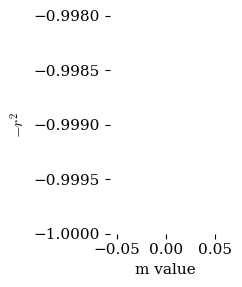

The optimal value for r is nan for rsq = nan


/opt/anaconda3/envs/main/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


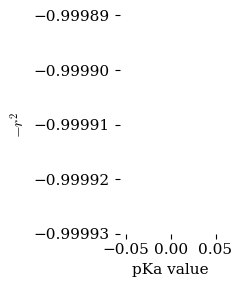

The optimal value for r is nan for rsq = nan
  message: NaN result encountered.
  success: False
   status: 3
      fun: nan
        x: [ 7.000e-01 -8.000e+00]
      nit: 0
      jac: [       nan        nan]
 hess_inv: [[1 0]
            [0 1]]
     nfev: 3
     njev: 1
The optimal value for m is -8.000 and for pka is 0.700 for rsq = nan


/opt/anaconda3/envs/main/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


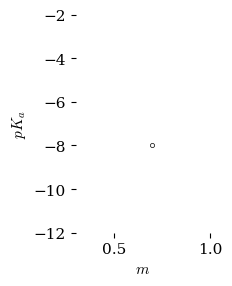

In [7]:
###################################################
### CURVE FIT FOR PARAMETERS
###################################################

# Try to curve fit for m, pKa and maybe n


def RSQ_function(m):    # returns the RSQ for linefits using the given m factor
    pKa = -9.5
    Ka=10**-pKa
    h_0 = 10**-df1["H0"]
    x = np.log10(df1["Molar_aH2O"]) 
#    y = df1["log_k_obs"]+ m * df1["H0"]
    y = df1["log_k_obs"]- np.log10(h_0**m/(Ka**m + h_0**m))
    linfit = linregress(x,y)
    return -(linfit.rvalue**2)

def RSQ_function2(pKa):    # returns the RSQ for linefits using the given pKa Value
    m = 0.72
    h_0 = 10**-df1["H0"]
    Ka = 10**-pKa
    x = np.log10(df1["Molar_aH2O"]) 
    y = df1["log_k_obs"]- np.log10(h_0**m/(Ka**m + h_0**m))
    linfit = linregress(x,y)
    return -(linfit.rvalue**2)


##########################################################
### Plot the value of -RSQ as the value of r is varied ###
##################################################

style_file = "tufte.mplstyle"
#style_file = "S2_classic2.mplstyle"
plt.style.use(github_location_styles + style_file)        

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(2.5,3))  
ax.margins(x=.07, y=.07, tight=True)      # add 7% empty space around outside of plot area   
ax.set(ylabel=r"$-r^2$", 
       xlabel=r"m value",
#       xlim=[0.3,1.0],                  
       ylim=[-1,-0.998]
)

rsq_range=[]
r_range = np.arange(0.5,1,0.01)
for r in r_range:
    rsq = RSQ_function(r)
    rsq_range.append(rsq)
    
ax.plot(r_range,rsq_range)

#fig.savefig("plot.pdf")   # use this to save the figure in PDF format
plt.show()

##################################################
### Determine optimal r value to minimize -RSQ ###
##################################################

r_opt = minimize_scalar(RSQ_function)
print(f"The optimal value for r is {r_opt['x']:0.3f} for rsq = {r_opt['fun']:0.5f}")



##########################################################
### Plot the value of -RSQ as the value of r is varied ###
##################################################

style_file = "tufte.mplstyle"
#style_file = "S2_classic2.mplstyle"
plt.style.use(github_location_styles + style_file)        

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(2.5,3))  
ax.margins(x=.07, y=.07, tight=True)      # add 7% empty space around outside of plot area   
ax.set(ylabel=r"$-r^2$", 
       xlabel=r"pKa value",
#       xlim=[0.3,1.0],                  
       ylim=[-0.99993,-0.99989]
         )


rsq_range=[]
r_range = np.arange(-11,-6.0,0.1)
for r in r_range:
    rsq = RSQ_function2(r)
    rsq_range.append(rsq)
    
ax.plot(r_range,rsq_range)

#fig.savefig("plot.pdf")   # use this to save the figure in PDF format
plt.show()

##################################################
### Determine optimal r value to minimize -RSQ ###
##################################################

r_opt = minimize_scalar(RSQ_function2)
print(f"The optimal value for r is {r_opt['x']:0.3f} for rsq = {r_opt['fun']:0.5f}")








### CONTOUR PLOT


################################################################################
### Define a function to be minimized
################################################################################


def RSQ_function3(params):    # returns the RSQ for linefits using the given Yukawa-Tsuno r factor
    m, pKa = params
    h_0 = 10**-df1["H0"]
    Ka = 10**-pKa
    x = np.log10(df1["Molar_aH2O"]) 
    y = df1["log_k_obs"]- np.log10(h_0**m/(Ka**m + h_0**m))
    linfit = linregress(x,y)
    return -(linfit.rvalue**2)


################################################################################
### optimize the param list to obtain the minimum result of the function.
################################################################################

r_opt = minimize(RSQ_function3, [0.7,-8])
#print(r_opt)
r_minus, r_plus = r_opt['x']
print(r_opt)
print(f"The optimal value for m is {r_plus:0.3f} and for pka is {r_minus:0.3f} for rsq = {r_opt['fun']**2:0.5f}")

################################################################################
### Create a plot object
################################################################################

style = "tufte.mplstyle"
#style = "S2_classic2.mplstyle"
style_name = github_location_styles + style
plt.style.use(style_name)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(2.5,3))  
ax.margins(x=.07, y=.07, tight=True)

ax.set(
#    title="Yukawa-Tsuno Plot",       
          ylabel=r"$pK_a$", 
          xlabel=r"$m$",                
          xlim=[0.3,1.0],                  
          ylim=[-12,-2]
         )

################################################################################
### use the function to caluate the RSQ for the line fit at every value of r+ and r-
## and then plot the result as a contour plot
################################################################################

mlist = np.linspace(0.3, 1.0, 50)
pKalist = np.linspace(-12.0, -2.0, 50)         #  vary r_plus and r_minus from -1.1 to +1.1

### This loop cycles through all the pairings of r+ and r- and calculates RSQ for each case
l1 = []                                
for pKa in pKalist:
    l2 = []
    for m in mlist:
        rsq = RSQ_function3([m,pKa])    
        l2.append(rsq)
    l1.append(l2)
l3 = np.matrix(l1)
#print(l3)

### Set up contour plot
X, Y = np.meshgrid(mlist, pKalist)
#levels = [0.95,0.96,0.97, 0.98, 0.99, 0.995, 0.999, 0.9998]
#levels = [0.90,0.95,0.97, 0.98, 0.995, 0.999, 0.9998]
levels = [0.90,0.95,0.97, 0.99, 0.999]

### plot lines along the x and y axes
ax.hlines(0,-1,1, color = "lightgray", zorder = 1, linewidths=0.5)
ax.vlines(0,-1,1, color = "lightgray", zorder = 1, linewidths=0.5)

### Plot the contour lines as thick white lines 
#ax.contour(X, Y, -l3, levels, colors = "white", linewidths=3, zorder = 2)

### Create contour plot as 'CS' and then plot 'CS' with lables
CS = ax.contour(X, Y, -l3, levels, colors = "black", linewidths=0.5, zorder = 2)
ax.clabel(CS, inline=True, fontsize=9)

### Plot the true minimum value as a point
ax.plot(r_minus,r_plus,"o", color="white", markeredgecolor = "black", markeredgewidth = 0.5, markersize = 3)
#ax.plot(pKa,m,"o", color="black", markersize = 2)

#ax.hlines(-9.5,0.3,1, color ="red", linewidths =0.5, zorder=0)
#ax.vlines(0.73,-12,-2, color ="red", linewidths =0.5, zorder=0)


################################################################################
### Output the plot to a pdf file and show it in this notebook.
################################################################################


fig.savefig("fig15.pdf")   # use this to save the figure in PDF format

plt.show()

#print(mlist)
#print(pKalist)





/opt/anaconda3/envs/main/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


LinregressResult(slope=nan, intercept=nan, rvalue=nan, pvalue=nan, stderr=nan, intercept_stderr=nan)


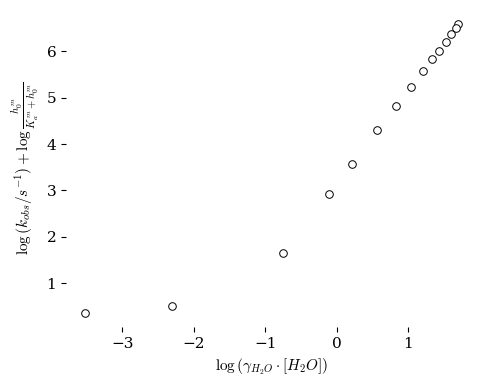

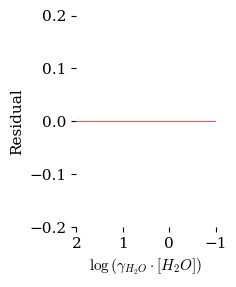

In [11]:
###################################################
### MAKE PLOT
###################################################

pKa = -9.5
#pKa = -4.95

Ka = 10**-pKa

h_0 = 10**-df1["H0"]

m = 0.72
#m = 0.54

###################################################
### Select the data for ESTER HYDROLYSIS
###################################################

#x = np.log10(df1["aH2O"])
x = np.log10(df1["Molar_aH2O"])

#y = df1["log_k_obs"]
y = df1["log_k_obs"]-np.log10(h_0**m/(Ka**m + h_0**m))
#y = df1["log_k_obs"] + m * df1["H0"]


###################################################
### Create figure for plot
###################################################

style = "tufte.mplstyle"
#style = "S2_classic2.mplstyle"
style_name = github_location_styles + style
plt.style.use(style_name)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,4))  
#ax2 = ax.twinx()

###################################################
### Set up labels
###################################################

#x_label = r"$\%wt {H_2SO_4}$"
#x_label = r"$\log{a_{H_2O}}$"
x_label = r"$\log{(\gamma_{H_2O} \cdot [{H_2O}])}$"

#y_label = r"$\log{(k_{obs} / {s}^{-1})} + mH_0$"
y_label = r"$\log{(k_{obs} / {s}^{-1})} + \log\frac{h_0^m}{K_a^m+h_0^m}$"

###################################################
### RATE vs ACIDITY Plot
###################################################

if True:                  # Set up axes for main plot
    ax.set(ylabel=y_label, xlabel=x_label,
#           xlim=[2,-1],
#           ylim=[6.5,0.9]
           )

if True:                       # Data points for kobs vs Acidity
    ax.scatter(x, y, 
              marker = "o", s = 30, 
              color = "white", edgecolors = "black", linewidths=0.7, 
              zorder = 2)
    ax.scatter(x, y,           # White circle behind each data point 
              marker = "o", s = 90, 
              color = "white", 
              zorder = 1)


a = linregress(x,y)
print(a)
y_line = a.slope * x + a.intercept

ax.plot(x, y_line,    # Plot line fit
        "-", color = "black", linewidth=0.7, 
        zorder = 0)

plt.savefig("fig16.pdf")
plt.show()


###################################################
### Create figure for RESIDUAL plot
###################################################

style = "tufte.mplstyle"
#style = "S2_classic2.mplstyle"
style_name = github_location_styles + style
plt.style.use(style_name)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(2.5,3))  

###################################################
### Set up labels
###################################################

#x_label = r"$\log{a_{H_2O}}$"
x_label = r"$\log{(\gamma_{H_2O} \cdot [{H_2O}])}$"

y_label = "Residual"

###################################################
### Plot the residuals
###################################################

ax.set(ylabel=y_label, xlabel=x_label,
           xlim=[2,-1],
           ylim=[-.2,.2]
        )

ax.plot(x, y-y_line,    # Plot line fit
        "-", color = "white", linewidth=3, 
        zorder = 1)
ax.plot(x, y-y_line,    # Plot line fit
        "-", color = "black", linewidth=0.7, 
        zorder = 1)

ax.scatter(x, y-y_line,           # White circle behind each data point 
          marker = "o", s = 90, 
          color = "white", 
          zorder = 2)
ax.scatter(x, y-y_line, 
          marker = "o", s = 30, 
          color = "white", edgecolors = "black", linewidths=0.7, 
          zorder = 2)

#ax.hlines(0,np.min(x),np.max(x), color ="red", linewidths =0.5, zorder=0)
ax.hlines(0,-1,2, color ="red", linewidths =0.5, zorder=0)

plt.savefig("fig16r.pdf")
plt.show()


LinregressResult(slope=2.0126754231252466, intercept=2.931482188788384, rvalue=0.9999487626387326, pvalue=2.689903001823023e-23, stderr=0.006143310495002412, intercept_stderr=0.007326693070337065)


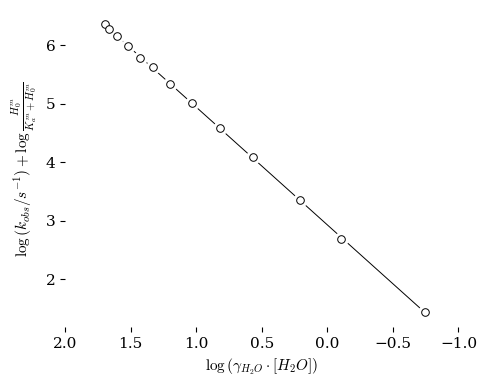

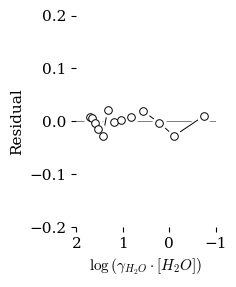

In [ ]:
###################################################
### MAKE PLOT
###################################################

pKa = -9.5
#pKa = -4.95

Ka = 10**-pKa

h_0 = 10**-df1["H0"]

m = 0.72
#m = 0.54

###################################################
### Select the data for ESTER HYDROLYSIS
###################################################

#x = np.log10(df1["aH2O"])
x = np.log10(df1["Molar_aH2O"])

#y = df1["log_k_obs"]
y = df1["log_k_obs"]-np.log10(h_0**m/(Ka**m + h_0**m))
#y = df1["log_k_obs"] + m * df1["H0"]


###################################################
### Create figure for plot
###################################################

style = "tufte.mplstyle"
#style = "S2_classic2.mplstyle"
style_name = github_location_styles + style
plt.style.use(style_name)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,4))  
#ax2 = ax.twinx()

###################################################
### Set up labels
###################################################

#x_label = r"$\%wt {H_2SO_4}$"
#x_label = r"$\log{a_{H_2O}}$"
x_label = r"$\log{(\gamma_{H_2O} \cdot [{H_2O}])}$"

#y_label = r"$\log{(k_{obs} / {s}^{-1})} + mH_0$"
y_label = r"$\log{(k_{obs} / {s}^{-1})} + \log\frac{H_0^m}{K_a^m+H_0^m}$"

###################################################
### RATE vs ACIDITY Plot
###################################################

if True:                  # Set up axes for main plot
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set(xlim=[2,-1],
           #ylim=[2.5,-0.5]
           #ylim=[2.5,-0.5]
           )

if True:                       # Data points for kobs vs Acidity
    ax.scatter(x, y, 
              marker = "o", s = 30, 
              color = "white", edgecolors = "black", linewidths=0.7, 
              zorder = 2)
    ax.scatter(x, y,           # White circle behind each data point 
              marker = "o", s = 90, 
              color = "white", 
              zorder = 1)


a = linregress(x,y)
print(a)
y_line = a.slope * x + a.intercept

ax.plot(x, y_line,    # Plot line fit
        "-", color = "black", linewidth=0.7, 
        zorder = 0)

plt.savefig("fig18.pdf")
plt.show()


###################################################
### Create figure for RESIDUAL plot
###################################################

style = "tufte.mplstyle"
#style = "S2_classic2.mplstyle"
style_name = github_location_styles + style
plt.style.use(style_name)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(2.5,3))  

###################################################
### Set up labels
###################################################

#x_label = r"$\log{a_{H_2O}}$"
x_label = r"$\log{(\gamma_{H_2O} \cdot [{H_2O}])}$"

y_label = "Residual"

###################################################
### Plot the residuals
###################################################

ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
ax.set(xlim=[2,-1],
        ylim=[-.2,.2]
        )

ax.plot(x, y-y_line,    # Plot line fit
        "-", color = "white", linewidth=3, 
        zorder = 1)
ax.plot(x, y-y_line,    # Plot line fit
        "-", color = "black", linewidth=0.7, 
        zorder = 1)

ax.scatter(x, y-y_line,           # White circle behind each data point 
          marker = "o", s = 90, 
          color = "white", 
          zorder = 2)
ax.scatter(x, y-y_line, 
          marker = "o", s = 30, 
          color = "white", edgecolors = "black", linewidths=0.7, 
          zorder = 2)

#ax.hlines(0,np.min(x),np.max(x), color ="red", linewidths =0.5, zorder=0)
ax.hlines(0,-1,2, color ="red", linewidths =0.5, zorder=0)

plt.savefig("fig18r.pdf")
plt.show()
